## Q5 (Bonus): Predict Indices in the next 5 days : Model


In [ ]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=3)
from sklearn.preprocessing import StandardScaler

# data = pd.read_csv("Processed_S&P.csv", parse_dates=[0])
data = pd.read_csv("/content/drive/MyDrive/BIA_667_Intro_DL/assignments/assignment4/Processed_S&P.csv", parse_dates=[0])
data = data[["Date", "Close", "Volume", \
             "mom", "mom1", "mom2", "mom3",\
            "ROC_5","ROC_10","ROC_15","ROC_20",\
            "EMA_10","EMA_20","EMA_50"]]

# drop NA
data = data.dropna(axis = 0)
print("Start date: ", data["Date"].min())
print("End date: ", data["Date"].max())
print(len(data))
# data.head(10)

Start date:  2010-03-15 00:00:00
End date:  2017-11-15 00:00:00
1935


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

def transform_data(data, feature_cols, target_col, cut_off_index, lookback=5, predict_day=1):
    train, test  = data[:cut_off_index], data[cut_off_index:]

    scalarX = StandardScaler()
    scalar_x = scalarX.fit(train[feature_cols])
    scalarY = StandardScaler()
    scalar_y = scalarY.fit(train[target_col].to_numpy().reshape(-1,1))
    
    X = scalar_x.transform(data[feature_cols])
    Y = scalar_y.transform(data[target_col].to_numpy().reshape(-1,1))

    # X = sliding_windows(scaled_X, lookback)
    Y_binary = (data['Close'][predict_day:] / data['Close'][:-predict_day].values).astype(int)


    return X, Y, Y_binary, scalar_x, scalar_y


target_col = "Close"
lookback = 5
train_test_cut_off = int(len(data)*0.8)
feature_cols = ["Close","Volume", "mom", "mom1", "mom2", "mom3","ROC_5","ROC_10","ROC_15","ROC_20","EMA_10","EMA_20","EMA_50"]  
X, Y, Y_binary, scalar_x, scalar_y = transform_data(data, feature_cols, target_col, train_test_cut_off, lookback)
# print("-----")
# print(pd.DataFrame(X[0:10]))
# print("---")
print(X.shape, Y.shape, Y_binary.shape)


(1935, 13) (1935, 1) (1934,)


In [ ]:
def sliding_windows(data, window):
    x = []
    for i in range(window, len(data)):
        if i >= len(data):
            break
        x.append(data[i-window:i])
    return np.array(x)

def sliding_windows_fwd(data, window):
    x = []
    for i in range(window, len(data)):
        if i+window >= len(data):
            break
        x.append(data[i:i+window])
    return np.array(x)

X_seq = sliding_windows(X, lookback)
Y_seq = sliding_windows_fwd(Y, lookback)

In [ ]:
print(X_seq.shape, Y_seq.shape) # verified right, now drop last 5 x as we dont have y for them

(1930, 5, 13) (1925, 5, 1)


In [ ]:
X_seq = X_seq[:-lookback]

In [ ]:
print(X_seq.shape, Y_seq.shape) 

(1925, 5, 13) (1925, 5, 1)


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
import numpy as np

In [ ]:
class SP_dataset(Dataset):
    def __init__(self, X, Y):
        # print("setting y shape",Y.shape)
        self.X = torch.tensor(X, dtype=torch.float)
        self.Y = torch.tensor(Y, dtype=torch.float)
        self.len = len(X)
    def __getitem__(self, index):
        return self.X[index], self.Y[index]
    def __len__(self):
        return self.len

In [ ]:
class SP_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(SP_Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, 
            hidden_dim, 
            layer_dim, 
            batch_first=True, 
            dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # Initializing hidden state for first input with zeros
        # print(x.shape)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        # print(out.shape)
        return out

In [ ]:
from sklearn.metrics import accuracy_score
# # Define a function to train the model 
def train_model(model, train_dataset, test_dataset, device, binary_pred = False,\
                lr=0.0005, epochs=20, batch_size=32):
    # Define the loss function
    if binary_pred:
        # criterion = nn.BCELoss()
        criterion = nn.BCEWithLogitsLoss()
    else:
        # criterion = nn.L1Loss()
        criterion = nn.MSELoss()


    # Define the optimizer
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Define the dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    # Train the model
    model = model.to(device)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5,
                                                               patience=20,
                                                               threshold=0.001,
                                                               threshold_mode='rel',
                                                               cooldown=0,
                                                               min_lr=0.00001,
                                                               eps=1e-08,
                                                               verbose=True)

    train_history = {'train_loss': [],
                    'train_acc': [],
                    'test_loss': [],
                    'test_acc': []}
    loss_list = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        val_acc = 0
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            
            
            if binary_pred:
                output = outputs.view(-1)
                predicted = torch.sigmoid(output)
                # predicted = output
                cur_train_loss = criterion(predicted, y_binary)
                train_loss += cur_train_loss
                
                # pred_bin = np.round(predicted.cpu().detach().numpy())
                pred_bin = (predicted > 0.5).int()
                y_bin = y_binary.cpu().detach().numpy()
                acc_score = accuracy_score(y_bin, pred_bin)
                train_acc +=  acc_score
                
            else:
                y = y.squeeze()
                # print("outputs of size", outputs.shape)
                # print("y shape", y.shape)
                cur_train_loss = criterion(outputs, y)
                train_loss += cur_train_loss

            loss_list.append(cur_train_loss.item())
            cur_train_loss.backward()
            scheduler.step(np.array(loss_list).mean())
            optimizer.step()
            optimizer.zero_grad()
             
        
        
        model.eval()
        with torch.no_grad():
            for x, y in test_loader: # ignore binary label
                # move
                x = x.to(device)
                y = y.to(device)
                outputs = model(x)

                if binary_pred:
                    output = outputs.view(-1)
                    predicted = torch.sigmoid(output)
                    # predicted = output
                    
                    
                    cur_test_loss = criterion(predicted, y_binary)
                    test_loss += cur_test_loss  # sum up batch loss

                    # curr_test_acc = (predicted == y_binary).sum().item() / batch_size
                    # test_acc +=  curr_test_acc
                    # pred_bin = np.round(predicted.cpu().detach().numpy())
                    pred_bin = (predicted > 0.5).int()
                    y_bin = y_binary.cpu().detach().numpy()
                    acc_score = accuracy_score(y_bin, pred_bin)
                    test_acc +=  acc_score
                    
                else:
                    y = y.squeeze()
                    cur_test_loss = criterion(outputs, y)
                    test_loss += cur_test_loss  # sum up batch loss

        
        train_loss = (train_loss/len(train_loader))
        train_acc = train_acc/len(train_loader)
        val_loss = (test_loss/len(test_loader))
        val_acc = test_acc/len(test_loader)

        train_history['train_loss'].append(train_loss)
        train_history['train_acc'].append(train_acc)
        train_history['test_loss'].append(val_loss)
        train_history['test_acc'].append(val_acc)
        print(f"Epoch:{epoch + 1} / {epochs}, train_loss:{train_loss:.5f} train_acc:{train_acc:.5f}, test_loss:{val_loss:.5f} test_acc:{val_acc:.5f}")
        # display.clear_output(wait=True)
 
    return train_history
    

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X_seq.shape, Y_seq.shape
X_train = X_seq[:train_test_cut_off]
Y_train = Y_seq[:train_test_cut_off]
train_dataset = SP_dataset(X_train, Y_train)


X_test = X_seq[train_test_cut_off:]
Y_test = Y_seq[train_test_cut_off:]
test_dataset = SP_dataset(X_test, Y_test)


input_dim = len(feature_cols)
hidden_dim = 128
output_dim = 5
num_layers = 2
dropout = 0.2
model_reg = SP_Model(input_dim=input_dim, hidden_dim=hidden_dim, layer_dim=num_layers, output_dim=output_dim, dropout_prob=dropout)
hista = train_model(model_reg, train_dataset, test_dataset, device, binary_pred = False,lr=0.0001, epochs=100, batch_size=32)

Epoch    26: reducing learning rate of group 0 to 5.0000e-05.
Epoch    47: reducing learning rate of group 0 to 2.5000e-05.
Epoch:1 / 100, train_loss:0.93441 train_acc:0.00000, test_loss:3.78217 test_acc:0.00000
Epoch:2 / 100, train_loss:0.85432 train_acc:0.00000, test_loss:3.51037 test_acc:0.00000
Epoch:3 / 100, train_loss:0.77267 train_acc:0.00000, test_loss:3.07677 test_acc:0.00000
Epoch:4 / 100, train_loss:0.64781 train_acc:0.00000, test_loss:2.42407 test_acc:0.00000
Epoch:5 / 100, train_loss:0.47578 train_acc:0.00000, test_loss:1.58293 test_acc:0.00000
Epoch:6 / 100, train_loss:0.28016 train_acc:0.00000, test_loss:0.86075 test_acc:0.00000
Epoch:7 / 100, train_loss:0.12717 train_acc:0.00000, test_loss:0.49193 test_acc:0.00000
Epoch:8 / 100, train_loss:0.05086 train_acc:0.00000, test_loss:0.37711 test_acc:0.00000
Epoch:9 / 100, train_loss:0.02622 train_acc:0.00000, test_loss:0.34524 test_acc:0.00000
Epoch:10 / 100, train_loss:0.01944 train_acc:0.00000, test_loss:0.33385 test_acc:0.0

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history, binary_pred):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='train_loss')
    plt.plot(epochs, history['test_loss'], 'r-', label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    if binary_pred:
        epochs = range(1, len(history['train_acc']) + 1)
        plt.plot(epochs, history['train_acc'], 'b-', label='train_acc')
        plt.plot(epochs, history['test_acc'], 'r-', label='test_acc')

        plt.title('Test Acc')
        plt.xlabel('Epochs')
        plt.ylabel('Acc')
        plt.legend()

        plt.show()

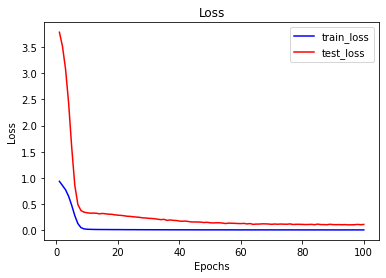

In [ ]:
plot_history(hista, binary_pred = False)